In [70]:
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
import seaborn as sns
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, train_test_split, StratifiedKFold, cross_validate
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import precision_recall_fscore_support, make_scorer, recall_score, f1_score, confusion_matrix, precision_score, balanced_accuracy_score
from sklearn.metrics import fbeta_score, classification_report

from sklearn.metrics import silhouette_score, silhouette_samples, homogeneity_score, fowlkes_mallows_score, adjusted_mutual_info_score
from sklearn.metrics import mean_squared_error
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture as GMM
from sklearn.decomposition import PCA, FastICA
from sklearn.random_projection import SparseRandomProjection as RCA
from collections import defaultdict
from itertools import product
from sklearn.metrics.pairwise import pairwise_distances
import scipy.sparse as sps
from scipy.linalg import pinv
from sklearn.ensemble import RandomForestClassifier

import os

from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from libs.loader import load_malicious, load_jobchange, load_jobchange_test_untouched, load_malicious_test_untouched, load_jobchange_w_headers, load_malicious_w_headers
         

from sklearn.model_selection import learning_curve, validation_curve

In [182]:
#Load the two datset
job_data = load_jobchange()
mal_data = load_malicious()

_X_job,y_job = job_data
_X_mal,y_mal = mal_data


minMaxNorm = MinMaxScaler()
X_job = minMaxNorm.fit_transform(_X_job)
X_mal = minMaxNorm.fit_transform(_X_mal)

_X_test_mal, y_test_mal = load_malicious_test_untouched()
_X_test_job, y_test_job = load_jobchange_test_untouched()
X_test_mal = minMaxNorm.fit_transform(_X_test_mal)
X_test_job = minMaxNorm.fit_transform(_X_test_job)

RND_STATE=998756

LABELS_MAL=['X_1','X_2','X_3','X_4','X_5','X_6','X_7','X_8','X_9','X_10','X_11','X_12','X_13','X_14','X_15']
LABELS_JOB=['city','city_development_index','gender','relevent_experience','enrolled_university','education_level','major_discipline','experience','company_size','company_type','last_new_job','training_hours']

LABELS_JOB_W_IDX = [f"[{i}] {LABELS_JOB[i]}" for i in range(len(LABELS_JOB))  ]

PLOT_DIR = 'plots/em'
OUTPUT_DIR = 'output'
DR_DIR = 'plots/dr'
os.makedirs(PLOT_DIR, exist_ok=True)
os.makedirs(OUTPUT_DIR, exist_ok=True)
os.makedirs(DR_DIR, exist_ok=True)


In [248]:
LABELS_JOB[11]

'training_hours'

In [116]:
def get_em_results_names():
    cv_types = ["spherical", "tied", "diag", "full"]
    score_types = ["sil","bic","hom", "fowm", "ami"]
    names = [f"{sc}_{cv}" for sc in score_types for cv in cv_types] 
    return names



def get_em_scores(X, y, N):


    def get_em(n, cv_t):
        gmm = GMM(n_components=n, covariance_type=cv_t, warm_start=True, random_state=RND_STATE)
        gmm.fit(X)
        gmm_labels = gmm.predict(X)

        ss = silhouette_score(X, gmm_labels, metric='euclidean')
        bic = gmm.bic(X)
#         hom = homogeneity_score(y, gmm_labels)

        fowm = fowlkes_mallows_score(y, gmm_labels)
#         ami = adjusted_mutual_info_score(y,gmm_labels)
        hom,ami = 0, 0
        return ss, bic, hom, fowm, ami
    
    cv_types = ["spherical", "tied", "diag", "full"]
        
    
    n_rng = np.arange(2,N+1)
    
    names =['n'] + get_em_results_names()

    scores_df = pd.DataFrame(columns=names)

    for n in n_rng:
        results = {'n':n}
        for cv_t in cv_types:
            ss_em, bic, hom, fowm, ami = get_em(n,cv_t)            
            results[ f"sil_{cv_t}"] =  ss_em; results[f"bic_{cv_t}"] = bic ; results[f"hom_{cv_t}"] = hom; results[f"fowm_{cv_t}"] = fowm; results[f"ami_{cv_t}"] = ami
        print(f" done with N: {n}")
        
        scores_df = scores_df.append(results, ignore_index=True)
            

    return scores_df

In [78]:
def plot_elbow_em(k_metric_df, name='dsname', short_name='shortname', face_color=None):
    
    figsave=False
    
    
    fig = plt.figure(figsize=[20,5])
    ax1 = fig.add_subplot(151)
    ax2 = fig.add_subplot(152)
    ax3 = fig.add_subplot(153)
    ax4 = fig.add_subplot(154)
    ax5 = fig.add_subplot(155)
    allAxs = [ax1, ax2, ax3, ax4, ax5] 

    
    x_vals = k_metric_df['n'].values
    x_vals = x_vals.astype('int32')

    for cv_t in ["spherical", "tied", "diag", "full"]:
        
        ax1.plot(x_vals, k_metric_df['sil_'+cv_t], label=f"{cv_t}")
        ax2.plot(x_vals, k_metric_df['bic_'+cv_t], label=f"{cv_t}")
        ax3.plot(x_vals, k_metric_df['hom_'+cv_t], label=f"{cv_t}")
        ax4.plot(x_vals, k_metric_df['fowm_'+cv_t], label=f"{cv_t}")
        ax5.plot(x_vals, k_metric_df['ami_'+cv_t], label=f"{cv_t}")
   
    ax1.set_xticks(x_vals); ax2.set_xticks(x_vals); ax3.set_xticks(x_vals); ax4.set_xticks(x_vals);ax5.set_xticks(x_vals)
    
    if face_color != None:
        for ax in allAxs:
            ax.set_facecolor(face_color)

    ax1.legend(); ax1.set_ylabel("Silhouette Score"); ax1.set_xlabel("N clusters");ax1.grid(True)
    ax2.legend(); ax2.set_ylabel("Bic Score"); ax2.set_xlabel("N clusters");ax2.grid(True)
    ax3.legend(); ax3.set_ylabel("Homogeneity Score"); ax3.set_xlabel("N clusters"); ax3.grid(True)
    ax4.legend(); ax4.set_ylabel("Fowlkes-Mallows Score"); ax4.set_xlabel("N clusters"); ax4.grid(True)
    ax5.legend(); ax5.set_ylabel("AMI Score"); ax5.set_xlabel("N clusters"); ax5.grid(True)

    ax1.set_title('EM: Elbow silhouette score\n  dataset: %s '%name)
    ax2.set_title('EM: BIC score criteria.\n  dataset: %s '%name)
    ax3.set_title('EM: Homogeneity score\n  dataset: %s '%name)
    ax4.set_title('EM: Fowlkes-Mallows score\n  dataset: %s '%name)
    ax5.set_title('EM: Ajusted Mutual Information score\n  dataset: %s '%name)



    fig.tight_layout()

    if figsave:
        fig.savefig('plots/em_cov_%s_results.png'%short_name, bbox_inches='tight')
        plt.close(fig=fig)
    else:
        plt.show()

In [79]:
# cv_types = ["spherical", "tied", "diag", "full"]
# score_types = ["sil","bic"]

# names = [f"{sc}_{cv}" for sc in score_types for cv in cv_types] 

# new_names = ['k'] + names
# new_names

scores_df_mal = get_em_scores(X_mal, y_mal, 10)

 done with N: 2
 done with N: 3
 done with N: 4
 done with N: 5
 done with N: 6
 done with N: 7
 done with N: 8
 done with N: 9
 done with N: 10


In [28]:
scores_df_job = get_em_scores(X_job, y_job, 9)

 done with N: 2
 done with N: 3
 done with N: 4
 done with N: 5
 done with N: 6
 done with N: 7
 done with N: 8
 done with N: 9


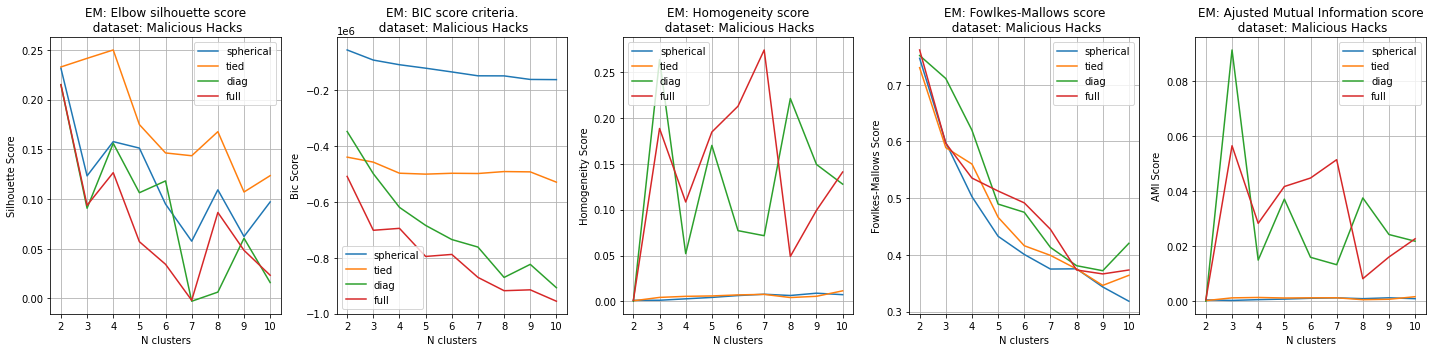

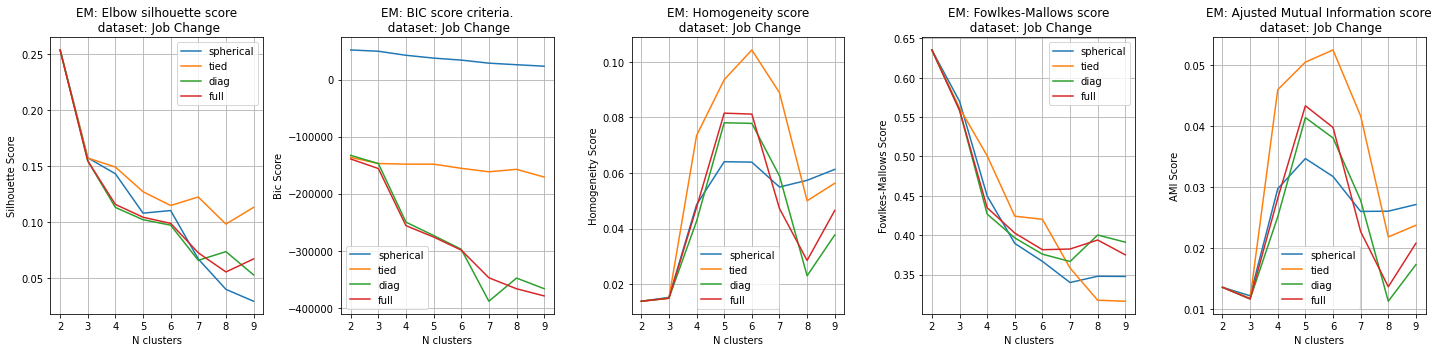

In [90]:
plot_elbow_em(scores_df_mal, 'Malicious Hacks', 'mal')
plot_elbow_em(scores_df_job, 'Job Change', 'job')

In [91]:
def max_kurtosis_indexes(X_projected, cutoff):
    tmp = pd.DataFrame(X_projected)
    tmp = tmp.kurt(axis=0)
    kurt = tmp.sort_values(ascending=False)
        
    max_k = kurt[0:cutoff]
    print(f"Top-{cutoff} Max Kurtosis -- ")
    print(max_k)
    print(max_k.index)
    return max_k.index
    
    

In [92]:
def ica_max_kurtosis(X, cutoff, dim=0):

    if dim == 0:
        dim = X.shape[1]-1
    elif dim < cutoff:
        dim = cutoff

    ica = FastICA(random_state=89143)
    ica.set_params(n_components=dim)
    X_projected = ica.fit_transform(X)

    max_k_idexes = max_kurtosis_indexes(X_projected,cutoff)
    
    X_proj_df = pd.DataFrame(X_projected)
    X_proj_df  = X_proj_df.filter( max_k_idexes, axis=1 )
        
    return X_proj_df
    

In [93]:
def ica_research(X, dim, cutoff):
    should_whiten = True
    ica = FastICA(dim, random_state=89143, whiten=should_whiten, max_iter=500)
    S_ = ica.fit_transform(X)
    A_ = ica.mixing_
    C_ = ica.components_
    
    max_k_idexes = max_kurtosis_indexes(S_,cutoff)
    
    mean_ = ica.mean_ if should_whiten else 0
    print(f"X.shape = {X.shape}")
    C_filtered = pd.DataFrame(C_).filter( max_k_idexes, axis=0)
    return A_, C_, C_filtered, mean_


In [205]:
A_ , C_, C_filtered, mean_ = ica_research(X_mal[:,:], 12, 3)
A_job , C_job,  C_filtered_job, mean_job = ica_research(X_job[:,:], 11, 1)

pd.DataFrame(C_filtered)
def plot_ica_dists(C_df,labels_list):
#     C_df.plot.bar()
   
    r,c = C_df.shape;
    fig, ax_val = plt.subplots(1, r, figsize=(r*7,5))
    ax = ax_val if type(ax_val) == np.ndarray else [ax_val]
    for i in range(r):
        ax[i].bar( C_df.columns, C_df.iloc[i,:].values)
        ax[i].set_xlabel('X Attribute')
        ax[i].set_xticks(C_df.columns)
        ax[i].set_xticklabels(labels_list)
        ax[i].tick_params(axis='x', labelrotation = -90)
        ax[i].set_ylabel('W(x_i)')
        ax[i].set_title(f"ICA Weight Distribution\nComponent Projection #{C_df.index[i]}")
        ax[i].axhline(y=0, color='k', linewidth=0.75)
    fig.tight_layout()
    plt.show()
    
def plot_ica_dists_v(C_df,labels_list, dsname, shortname, figsave=False, figsize=(5,3)):
   
    r,c = C_df.shape;
    fig, ax_val = plt.subplots(1, r, figsize=figsize)
    ax = ax_val if type(ax_val) == np.ndarray else [ax_val]
    for i in range(r):
        ax[i].barh( C_df.columns, C_df.iloc[i,:].values )
        ax[i].set_ylabel('X Attribute')
        ax[i].set_yticks(C_df.columns)
        ax[i].set_yticklabels(labels_list, fontsize=10)
        ax[i].set_xlabel('W(x_i)')
        ax[i].set_title(f"ICA Weight Distribution\n{dsname} dataset\nComponent Projection #{C_df.index[i]}")
        ax[i].axvline(x=0, color='k', linewidth=0.75)
    fig.tight_layout()
    if figsave:
        fig.savefig('%s/ica_weights_%s.png'%(DR_DIR,shortname), bbox_inches='tight')
        plt.close(fig=fig)
    else:
        plt.show()


plot_ica_dists_v(C_filtered, LABELS_MAL, 'Malicious', 'mal', figsave=True, figsize=(10,3))
plot_ica_dists_v(C_filtered_job, LABELS_JOB_W_IDX, 'Job Change', 'job', figsave=True)

Top-3 Max Kurtosis -- 
4     979.059926
10     16.442754
3       9.372346
dtype: float64
Int64Index([4, 10, 3], dtype='int64')
X.shape = (19084, 15)
Top-1 Max Kurtosis -- 
2    4.070954
dtype: float64
Int64Index([2], dtype='int64')
X.shape = (15326, 12)


In [106]:
def pca(X, cutoff_per, var_threashold):
    pca = PCA(cutoff_per, random_state=RND_STATE)
    pca.fit(X)
    pca.explained_variance_

    row_index = range(1, pca.explained_variance_.shape[0] + 1)
    ev = pd.Series(data=pca.explained_variance_, index=row_index)
    evr = pd.Series(data=pca.explained_variance_ratio_, index=row_index)
    eigen = pd.Series(data=pca.singular_values_, index=row_index)

    
    pca_stats_df = pd.DataFrame()
    pca_stats_df['pca_stats_df'] = ev
    pca_stats_df['e-variance-ratio'] = evr
    pca_stats_df['eigen'] = eigen

    var_above = pca_stats_df[pca_stats_df['pca_stats_df'] >= var_threashold]
    print("Original PCA components")
    print(pca_stats_df)
    print(f"Threshold PCA components variance >= [{var_threashold:.2f}%]")
    print(var_above)
  
    constrained_cols = var_above.index-1
    X_pca_projected = pca.transform(X)

    return pd.DataFrame(X_pca_projected).filter(constrained_cols, axis=1)


In [239]:
def cumsum_plotter(cumulativeSum):
    
    data = [n for n in range(len(cumulativeSum))]

    plt.figure(figsize=(5, 3))
    plt.plot(data, cumulativeSum, color='r', label='cumulative explained variance')
    plt.title('Cumulative Explained Variance vs Number of Components')
    plt.ylabel('Cumulative Explained variance')
    plt.xlabel('Principal components')
    plt.yticks([])
    plt.legend(loc='best')

def eigen_plotter(eigens, dsname, shortname, thresh, figsave=False):
    data = [n for n in range(len(eigens))]
    fig = plt.figure(figsize=(5, 3))
    plt.bar(data, eigens, color='purple',)
    plt.title(f'PCA Eigenvalue Distribution by component\n{dsname} dataset')
    plt.ylabel('eigenvalue')
    plt.xlabel('Principal components')
    plt.axhline(thresh, color='g', linewidth=0.85, label='threshold')
    plt.legend()
    if figsave:
        fig.savefig('%s/pca_eigen_%s.png'%(DR_DIR,shortname), bbox_inches='tight')
        plt.close(fig=fig)
    else:
        plt.show()



Running PCA with 15
Running PCA with 12


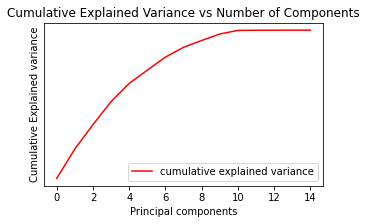

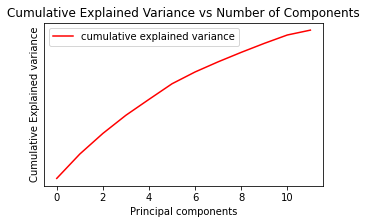

In [229]:
def pca_v_research(X,dsname, short_name, threshold):
    dim = X.shape[1]
    print(f"Running PCA with {dim}")
    pca = PCA( random_state=RND_STATE)
    pca.fit(X)
    cumulativeSum = np.cumsum(pca.explained_variance_ratio_) * 100
    cumsum_plotter(cumulativeSum)
    eigen_plotter(pca.explained_variance_, dsname, short_name, threshold, figsave=True)
    
_ =pca_v_research(X_mal, 'Malcious Hacks', 'mal',0.08)
_ =pca_v_research(X_job, 'Job Change', 'job',0.11)


In [195]:
def pca_research(X, cutoff_per):
    pca = PCA(cutoff_per, random_state=RND_STATE)
    pca.fit(X)

    row_index = range(1, pca.explained_variance_.shape[0] + 1)
    ev = pd.Series(data=pca.explained_variance_, index=row_index)
    evr = pd.Series(data=pca.explained_variance_ratio_, index=row_index)
    eigen = pd.Series(data=pca.singular_values_, index=row_index)
    
    C_ = pca.components_
    return C_



In [241]:
def plot_pca_dists_v(C_df,labels_list, dsname, shortname, figsave=False, figsize=(5,3)):
   
    r,c = C_df.shape;
    fig, ax_val = plt.subplots(1, r, figsize=figsize)
    ax = ax_val if type(ax_val) == np.ndarray else [ax_val]
    for i in range(r):
        ax[i].barh( C_df.columns, C_df.iloc[i,:].values )
        ax[i].set_ylabel('X Attribute')
        ax[i].set_yticks(C_df.columns)
        ax[i].set_yticklabels(labels_list, fontsize=10)
        ax[i].set_xlabel('W(x_i)')
        ax[i].set_title(f"PCA Weight Distribution\n{dsname} dataset\nComponent Projection #{C_df.index[i]}")
        ax[i].axvline(x=0, color='k', linewidth=0.75)
    fig.tight_layout()
    if figsave:
        fig.savefig('%s/pca_weights_%s.png'%(DR_DIR,shortname), bbox_inches='tight')
        plt.close(fig=fig)
    else:
        plt.show()
        
C_pca = pca_research(X_mal, 0.80)
C_pca_job = pca_research(X_job, 0.80)
C_pca_df = pd.DataFrame( C_pca )
C_pca_df_job = pd.DataFrame( C_pca_job )
# plot_ica_dists_v(C_filtered, LABELS_MAL, 'Malicious', 'mal', figsave=True, figsize=(10,3))
plot_pca_dists_v(C_pca_df.iloc[0:2,:], LABELS_MAL,'Malicious', 'mal', figsave=True)
plot_pca_dists_v(C_pca_df_job.iloc[0:1,:], LABELS_JOB_W_IDX, 'Job Change', 'job', figsave=True, figsize=(5,3))


In [236]:

def pairwiseDistCorr(X1,X2):
    assert X1.shape[0] == X2.shape[0]
    
    d1 = pairwise_distances(X1)
    d2 = pairwise_distances(X2)
    return np.corrcoef(d1.ravel(),d2.ravel())[0,1]

def reconstruction_error(projections, x):
    w = projections.components_
    if sps.issparse(w):
        w = w.todense()
    p = pinv(w)
    reconstructed = ((p@w)@(x.T)).T  # Unproject projected data
    
    errors = mean_squared_error(x,reconstructed)
#     errors = np.square(x-reconstructed)
    return np.nanmean(errors)

def rca_research(X, title, shortname, figsave=False):
    
#     dims = list(np.arange(2,(X.shape[1]-1),3))
    dims = range(2, X.shape[1] + 1)
#     dims.append(X.shape[1])
    recon_dict = defaultdict(dict)

    r_states = [89143, 92, 1081244453, 8772, 212]
    i = 0
    for r,dim in product(r_states,dims):
#         print(f"Iterating {r}-{dim}")
        rp = RCA(random_state=r, n_components=dim)
        rp.fit(X)
        recon_dict[dim][i%len(r_states)] = reconstruction_error(rp, X)
        i += 1
        
    tmp = pd.DataFrame(recon_dict).T
    print(tmp)
    mean_recon_df = tmp.mean(axis=1)
    mean_recon = mean_recon_df.tolist()
    std_recon = tmp.std(axis=1).tolist()
    
    print("*** reconstruction MSE***")
    print(mean_recon_df)
    


    fig, ax1 = plt.subplots()
    ax1.plot(dims,mean_recon, 'g-')
    ax1.set_xlabel('Random Components')
    # Make the y-axis label, ticks and tick labels match the line color.
    ax1.set_ylabel('Mean Reconstruction Error', color='g')
    ax1.tick_params('y', colors='g')
    plt.grid(True)

    ax2 = ax1.twinx()
    ax2.plot(dims,std_recon, linestyle='--', color='purple', linewidth=0.75)
    ax2.set_ylabel('STD Reconstruction Error', color='purple' )
    ax2.tick_params('y', colors='purple')
    plt.grid(False)

    plt.title("Random Components for 5 Restarts:\n"+ title+ "dataset")
    fig.tight_layout()
    if figsave:
        fig.savefig('%s/rp_recon_%s.png'%(DR_DIR,shortname), bbox_inches='tight')
        plt.close(fig=fig)
    else:
        plt.show()
    

In [231]:
def rp(X, dim, r_state=RND_STATE):
    rp = RCA(random_state=r_state, n_components=dim)
    fitted = rp.fit(X)
    X_rca_projected = rp.transform(X)
    return pd.DataFrame(X_rca_projected)
    

In [232]:
def rfc_research(X,y):
                 
        rfc = RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=RND_STATE, n_jobs=-1)
        fs = rfc.fit(X,y).feature_importances_

#         important_features = pd.Series(np.sort(fs)[::-1])
        return fs
        
def rfc(X,y):
                 
        rfc = RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=RND_STATE, n_jobs=-1)
        fs = rfc.fit(X,y).feature_importances_
        indexes_found = np.where(fs >= 0.10)
        
        X_reduced = pd.DataFrame(X)
        X_reduced = X_reduced.filter(indexes_found[0], axis=1)
        return X_reduced

In [233]:

#Research for Random Forest
important_mal = rfc_research(X_mal, y_mal)
# print("shape: ",important_mal.shape)
important_mal_df = pd.DataFrame( columns=LABELS_MAL)
df_length = len(important_mal_df)
important_mal_df.loc[df_length] = important_mal
print("*** importance mal***:")
print(pd.Series(important_mal))

print(rfc(X_mal, y_mal))

important_job = rfc_research(X_job, y_job)
important_job_df = pd.DataFrame( columns=LABELS_JOB)
df_length_job = len(important_job_df)
important_job_df.loc[df_length_job] = important_job

print("*** importance job***:")
print(pd.Series(important_job))

print(rfc(X_job, y_job))


*** importance mal***:
0     0.003659
1     0.028211
2     0.032212
3     0.012372
4     0.008923
5     0.017448
6     0.016480
7     0.017187
8     0.007016
9     0.476458
10    0.194951
11    0.069690
12    0.016623
13    0.015176
14    0.083595
dtype: float64
             9         10
0      0.000000  0.524096
1      0.000000  0.951807
2      0.020408  0.750000
3      0.000000  0.750000
4      0.000000  0.750000
...         ...       ...
19079  0.000000  0.951807
19080  0.000000  0.951807
19081  0.000000  0.524096
19082  0.000000  0.524096
19083  0.000000  0.000000

[19084 rows x 2 columns]
*** importance job***:
0     0.097302
1     0.194499
2     0.033160
3     0.019153
4     0.033577
5     0.038499
6     0.034425
7     0.116674
8     0.107981
9     0.062196
10    0.064798
11    0.197735
dtype: float64
             1         7      8         11
0      0.923913  0.000000  1.000  0.091667
1      0.891304  0.818182  0.125  0.454167
2      0.152174  0.500000  0.625  0.158333
3      0.

In [238]:
#Research how well RP is working
rca_research(X_mal, 'Malicious server hacks', 'mal',figsave=True)
rca_research(X_job, 'Job Change', 'job',figsave=True)


               0             4             3             2         1
2   2.560480e-01  2.618503e-01  2.573025e-01  2.085436e-01  0.203061
3   2.506717e-01  2.054778e-01  2.193374e-01  2.447870e-01  0.255828
4   1.605051e-01  1.979710e-01  2.375208e-01  1.722335e-01  0.254298
5   1.712613e-01  2.009069e-01  1.950871e-01  2.335290e-01  0.170920
6   1.973324e-01  1.808273e-01  2.130890e-01  1.667815e-01  0.190202
7   8.685544e-02  1.565573e-01  1.876197e-01  1.357217e-01  0.193338
8   1.400292e-01  1.319401e-01  1.121656e-01  1.474422e-01  0.184764
9   1.509738e-01  6.898074e-02  1.533007e-01  1.266305e-01  0.174474
10  1.161853e-01  7.316155e-02  5.791013e-02  1.649546e-01  0.099766
11  1.220118e-01  8.002316e-02  9.246701e-02  7.230034e-02  0.119032
12  4.279133e-02  5.479275e-02  4.644484e-02  6.127723e-02  0.043655
13  5.542054e-02  1.144936e-02  1.666373e-02  2.649431e-02  0.093889
14  6.023014e-02  3.818938e-02  4.033663e-03  7.388842e-02  0.027506
15  1.332307e-30  2.940379e-30  9.

## ALL Projections!

## ALL Projections!

## ALL Projections!

In [242]:

#KEY CODE BLOCK!!!
print(f"---- RUNNING ICA -------")
X_ica_proj_mal = ica_max_kurtosis(X_mal ,3, dim=12)
X_ica_proj_job = ica_max_kurtosis(X_job ,2, dim=11)

#Playing around with suggestions
# X_ica_proj_mal = ica_max_kurtosis(X_mal ,12, dim=12)
# X_ica_proj_job = ica_max_kurtosis(X_job ,11, dim=11)

print(f"\n---- RUNNING PCA -------")
X_pca_proj_mal = pca(X_mal, 0.80, 0.08)  #was 0.80, .10
X_pca_proj_job = pca(X_job, 0.80, 0.11) #was 0.80, .10

print(f"\n---- RUNNING RP -------")
r_states = [89143, 92, 1081244453, 8772, 212]
X_rp_proj_mal = []; X_rp_proj_job = []
for r in r_states:
    X_rp_mal = rp(X_mal,3, r) # was 10
    X_rp_job = rp(X_job,3, r) # was 9
    X_rp_proj_mal.append(X_rp_mal); X_rp_proj_job.append(X_rp_job)

print(f"\n---- RUNNING Random Forest RFC -------")
X_rfc_proj_mal = rfc(X_mal,y_mal)
X_rfc_proj_job = rfc(X_job,y_job)
print(f"Shapes for rfc:  mal.shape {X_rfc_proj_mal.shape} job.shape {X_rfc_proj_job.shape}")

---- RUNNING ICA -------
Top-3 Max Kurtosis -- 
4     979.059926
10     16.442754
3       9.372346
dtype: float64
Int64Index([4, 10, 3], dtype='int64')
Top-2 Max Kurtosis -- 
2    4.070954
6    2.281712
dtype: float64
Int64Index([2, 6], dtype='int64')

---- RUNNING PCA -------
Original PCA components
   pca_stats_df  e-variance-ratio      eigen
1      0.233921          0.268764  66.812563
2      0.126357          0.145178  49.104657
3      0.104607          0.120188  44.679041
4      0.098900          0.113632  43.443266
5      0.077852          0.089448  38.544098
6      0.057066          0.065566  32.999864
Threshold PCA components variance >= [0.08%]
   pca_stats_df  e-variance-ratio      eigen
1      0.233921          0.268764  66.812563
2      0.126357          0.145178  49.104657
3      0.104607          0.120188  44.679041
4      0.098900          0.113632  43.443266
Original PCA components
   pca_stats_df  e-variance-ratio      eigen
1      0.262442          0.243139  63.418657

In [115]:
print("Starting ICA Mal")
scores_df_ica_mal = get_em_scores(X_ica_proj_mal, y_mal, 7)
print("Starting ICA Job")
scores_df_ica_job = get_em_scores(X_ica_proj_job, y_job, 7)

Starting ICA Mal
 done with N: 2
 done with N: 3
 done with N: 4
 done with N: 5
 done with N: 6
 done with N: 7
Starting ICA Job
 done with N: 2
 done with N: 3
 done with N: 4
 done with N: 5
 done with N: 6
 done with N: 7


In [117]:
print("Starting PCA scores Mal")
scores_df_pca_mal = get_em_scores(X_pca_proj_mal, y_mal, 7)
print("Starting PCA scores Job")
scores_df_pca_job = get_em_scores(X_pca_proj_job, y_job, 7)

Starting PCA scores Mal
 done with N: 2
 done with N: 3
 done with N: 4
 done with N: 5
 done with N: 6
 done with N: 7
Starting PCA scores Job
 done with N: 2
 done with N: 3
 done with N: 4
 done with N: 5
 done with N: 6
 done with N: 7


In [243]:
scores_df_rp_mal = []; scores_df_rp_job =[]
for i in range(len(X_rp_proj_mal)):
    print(f"Starting RP scores Mal [{i}]")
    scores_df_rp_mal.append(get_em_scores(X_rp_proj_mal[i], y_mal, 6))
    print(f"Starting RP scores Job [{i}]")
    scores_df_rp_job.append(get_em_scores(X_rp_proj_job[i], y_job, 6))

Starting RP scores Mal [0]
 done with N: 2
 done with N: 3
 done with N: 4
 done with N: 5
 done with N: 6
Starting RP scores Job [0]
 done with N: 2
 done with N: 3
 done with N: 4
 done with N: 5
 done with N: 6
Starting RP scores Mal [1]
 done with N: 2
 done with N: 3
 done with N: 4
 done with N: 5
 done with N: 6
Starting RP scores Job [1]
 done with N: 2
 done with N: 3
 done with N: 4
 done with N: 5
 done with N: 6
Starting RP scores Mal [2]
 done with N: 2
 done with N: 3
 done with N: 4
 done with N: 5
 done with N: 6
Starting RP scores Job [2]
 done with N: 2
 done with N: 3
 done with N: 4
 done with N: 5
 done with N: 6
Starting RP scores Mal [3]
 done with N: 2
 done with N: 3
 done with N: 4
 done with N: 5
 done with N: 6
Starting RP scores Job [3]
 done with N: 2
 done with N: 3
 done with N: 4
 done with N: 5
 done with N: 6
Starting RP scores Mal [4]
 done with N: 2
 done with N: 3
 done with N: 4
 done with N: 5
 done with N: 6
Starting RP scores Job [4]
 done with

In [119]:
print("Starting RFC scores Mal")
scores_df_rfc_mal = get_em_scores(X_rfc_proj_mal, y_mal, 10)
print("Starting RFC scores Job")
scores_df_rfc_job = get_em_scores(X_rfc_proj_job, y_job, 9)

Starting RFC scores Mal
 done with N: 2
 done with N: 3
 done with N: 4
 done with N: 5
 done with N: 6
 done with N: 7
 done with N: 8
 done with N: 9
 done with N: 10
Starting RFC scores Job
 done with N: 2
 done with N: 3
 done with N: 4
 done with N: 5
 done with N: 6
 done with N: 7
 done with N: 8
 done with N: 9


In [120]:

def merge_scores_df_list(scores_df_list):
    scores_all_df = pd.DataFrame(scores_df_list[0])
    for i in range(1,len(scores_df_list)):
        scores_all_df += scores_df_list[i]
    
    scores_all_df = scores_all_df / len(scores_df_list)
    return scores_all_df
# JUST working out how to add together the various RP DataFrames
# scores_all_df_rp_mal = merge_scores_df_list(scores_df_rp_mal)
# scores_all_df_rp_job = merge_scores_df_list(scores_df_rp_job)
# print(f"{scores_all_df_rp_mal.shape}, {scores_df_rp_mal[0].shape}")
# print(f"{scores_all_df_rp_job.shape}, {scores_df_rp_job[0].shape}")
# scores_all_df_rp_mal

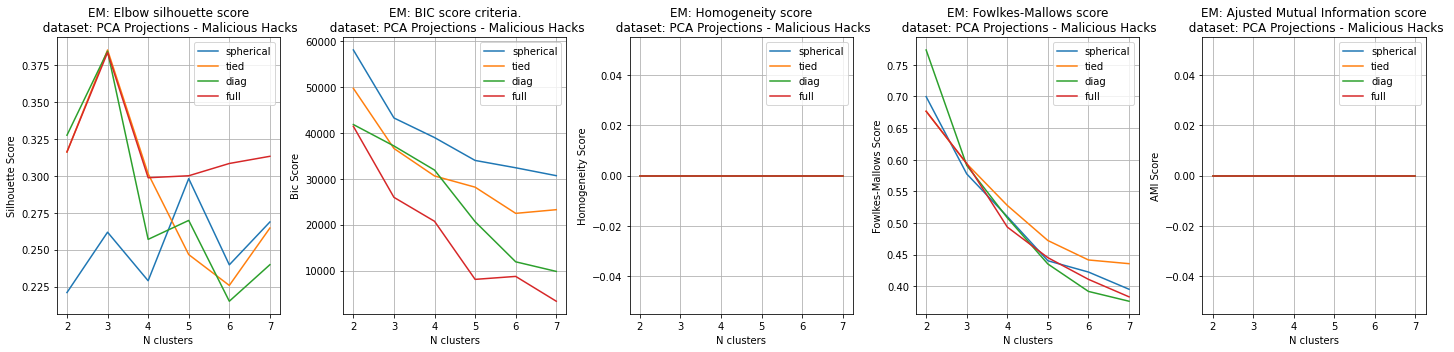

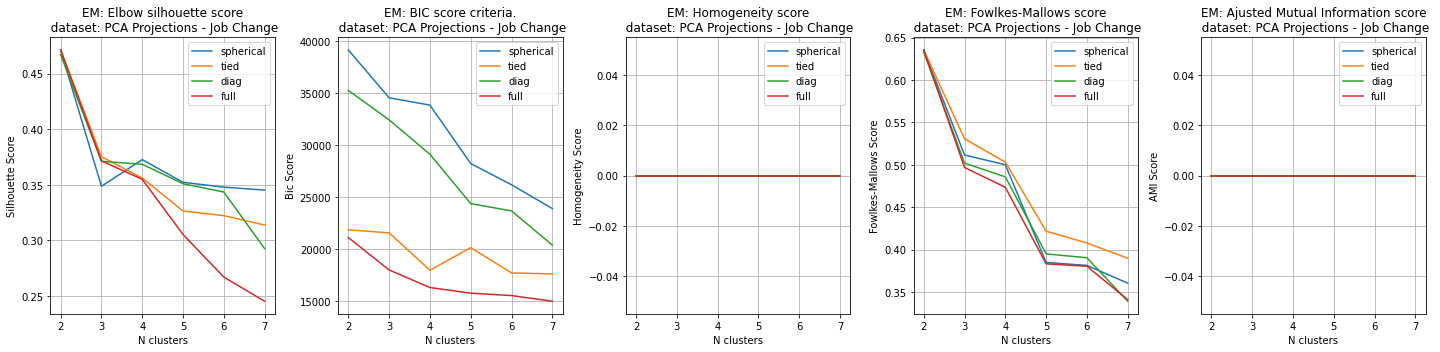

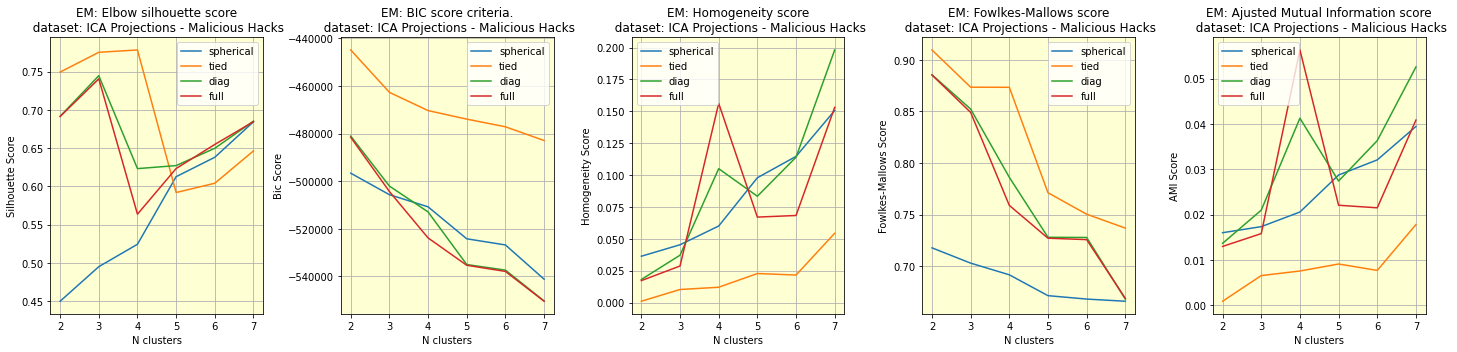

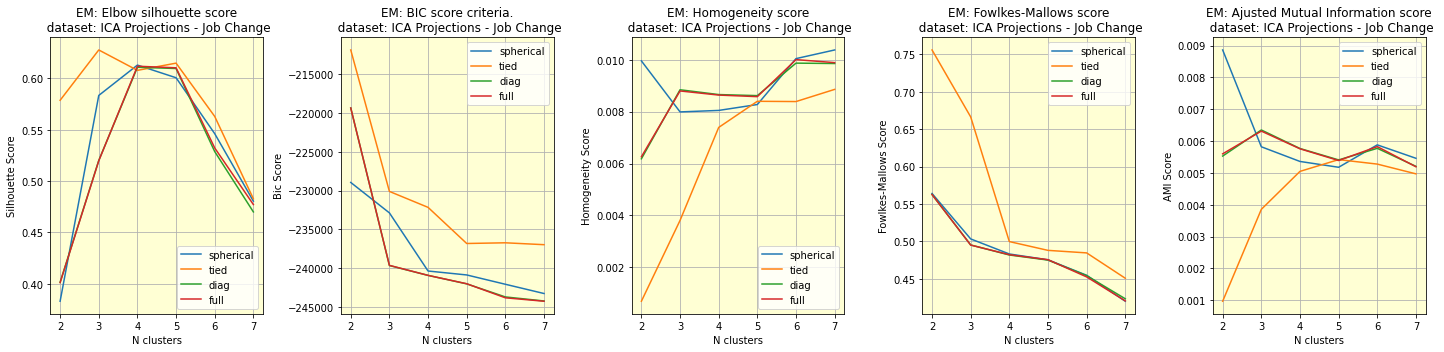

(5, 21), (5, 21)


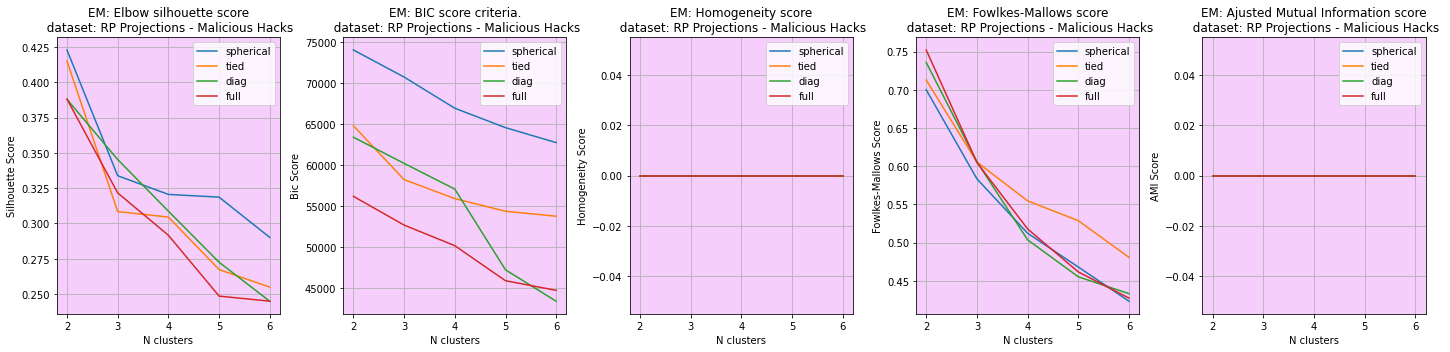

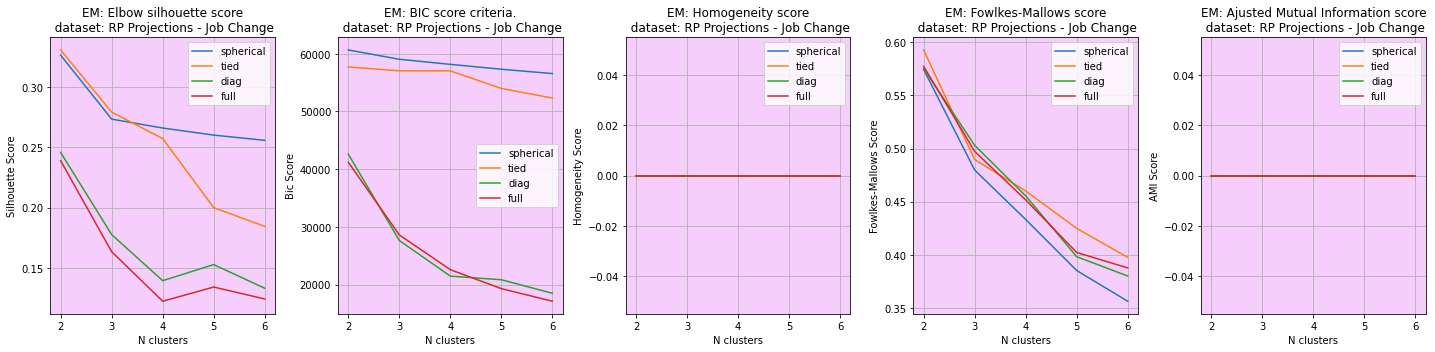

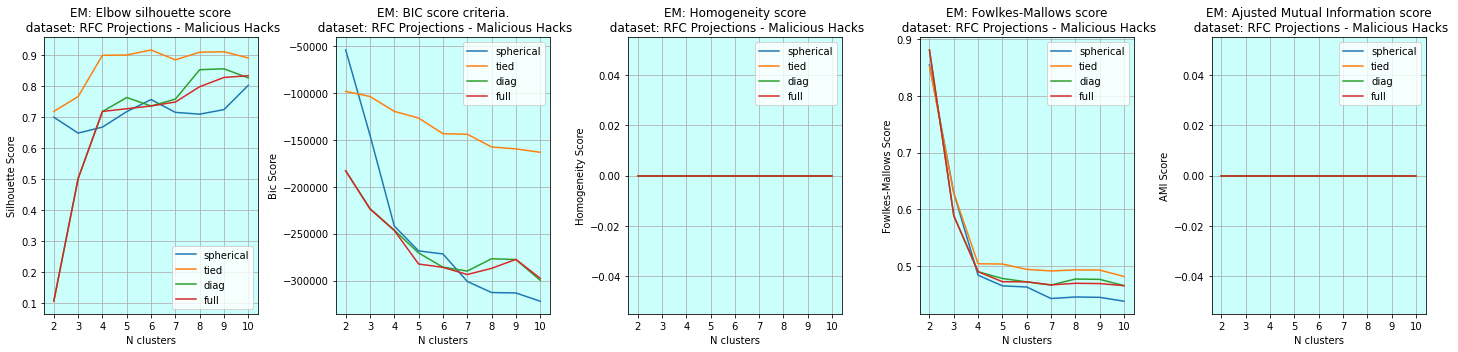

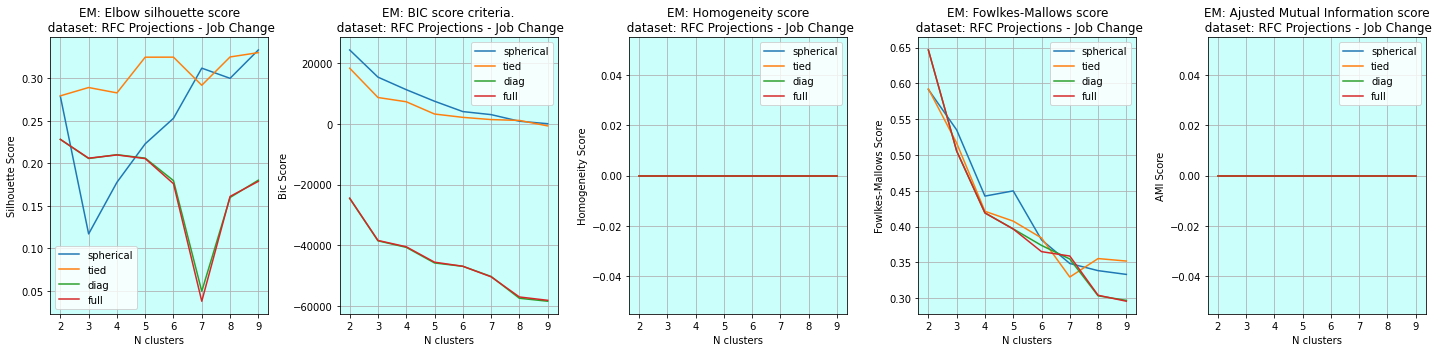

In [249]:

plot_elbow_em(scores_df_pca_mal, 'PCA Projections - Malicious Hacks', 'pca_mal')
plot_elbow_em(scores_df_pca_job, 'PCA Projections - Job Change', 'pca_job')

plot_elbow_em(scores_df_ica_mal, 'ICA Projections - Malicious Hacks', 'ica_mal', face_color='#ffffd4')
plot_elbow_em(scores_df_ica_job, 'ICA Projections - Job Change', 'ica_job',face_color='#ffffd4')

scores_all_df_rp_mal = merge_scores_df_list(scores_df_rp_mal)
scores_all_df_rp_job = merge_scores_df_list(scores_df_rp_job)
print(f"{scores_all_df_rp_mal.shape}, {scores_df_rp_mal[0].shape}")
plot_elbow_em(scores_all_df_rp_mal, 'RP Projections - Malicious Hacks', 'rp_mal', face_color='#f6cefc')
plot_elbow_em(scores_all_df_rp_job, 'RP Projections - Job Change', 'rp_job',face_color='#f6cefc')

plot_elbow_em(scores_df_rfc_mal, 'RFC Projections - Malicious Hacks', 'rfc_mal', face_color='#cafffb')
plot_elbow_em(scores_df_rfc_job, 'RFC Projections - Job Change', 'rfc_job',face_color='#cafffb')

In [250]:
def plot_em_pairwise(X, N, cv_type, title, d_key):
    
    gmm = GMM(n_components=N, covariance_type=cv_type, random_state=RND_STATE)
    gmm.fit(X)
    pred_clusters = gmm.predict(X)


    filtred_df = pd.DataFrame(X)
 
        
    filtred_df['pred'] = pred_clusters
#     ax = sns.pairplot(filtred_df, hue="pred", plot_kws={'alpha':0.5})
#     ax.fig.suptitle("%s, EM, N-cluster = %d"%(title,N), y=1.08)
#     ax.savefig('plots/pair_em_ica_%s_cluser%d.png'%(d_key,N))
    
    x_vars = filtred_df.columns[0:-1]
    y_vars = filtred_df.columns[0:1]
    ax = sns.PairGrid(filtred_df, hue="pred", x_vars=x_vars, y_vars=y_vars)
    ax.map_diag(sns.histplot, color=".3")
    ax.map_offdiag(sns.scatterplot)
    ax.add_legend()
    ax.fig.suptitle("%s, EM, N-cluster = %d"%(title,N), y=1.08)

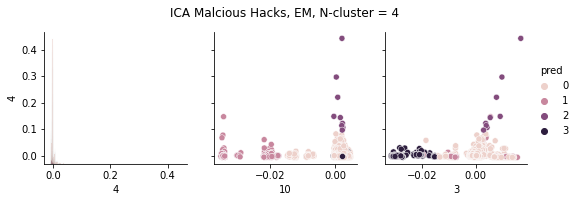

In [253]:
plot_em_pairwise(X_ica_proj_mal, 4, 'tied', 'ICA Malcious Hacks', 'mal')
# plot_em_pairwise(X_ica_proj_mal, 3, 'tied', 'ICA Malcious Hacks', 'mal')

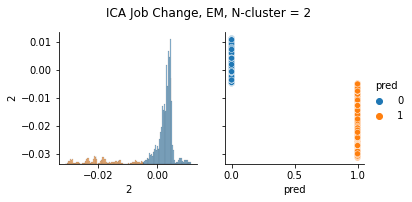

In [304]:
plot_em_pairwise(X_ica_proj_job, 2, 'full', 'ICA Job Change', 'job')

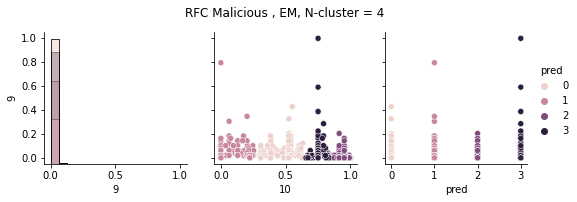

In [305]:
plot_em_pairwise(X_rfc_proj_mal, 4, 'tied', 'RFC Malicious ', 'mal')

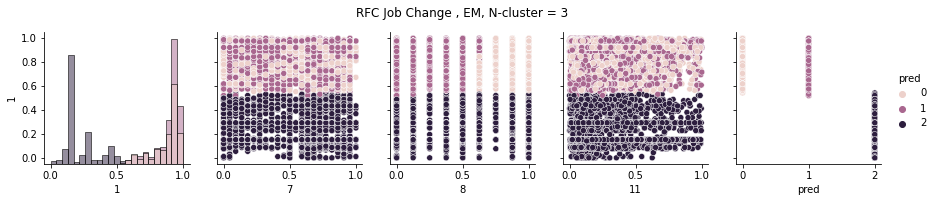

In [306]:
plot_em_pairwise(X_rfc_proj_job, 3, 'tied', 'RFC Job Change ', 'job')

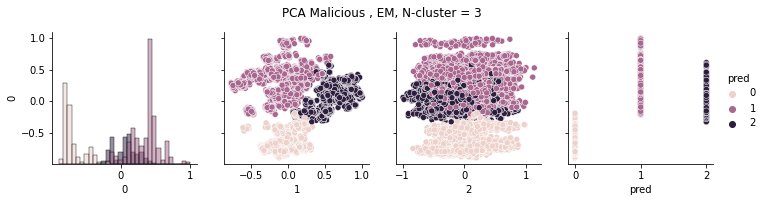

In [308]:
plot_em_pairwise(X_pca_proj_mal, 3, 'tied', 'PCA Malicious ', 'mal')

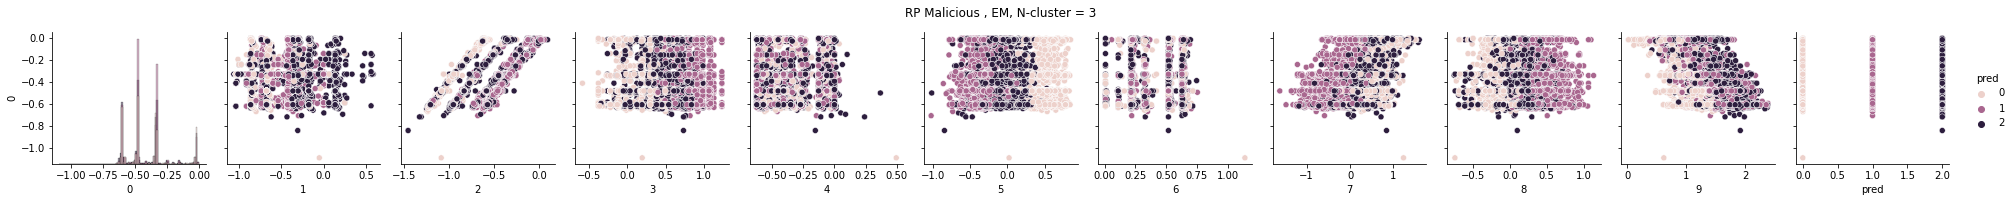

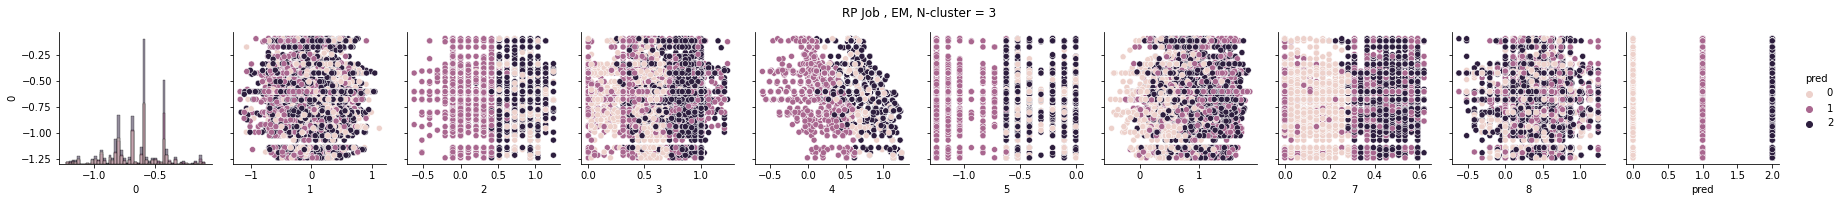

In [312]:
plot_em_pairwise(X_rp_proj_mal[0], 3, 'tied', 'RP Malicious ', 'mal')
plot_em_pairwise(X_rp_proj_job[0], 3, 'tied', 'RP Job ', 'mal')



In [159]:
def basic_km_plot_axis(k_metric_df, col_name, face_color=None):
        
    fig, ax1 = plt.subplots(1, 1, figsize=(3,3))

    x_vals = k_metric_df['n'].values
    x_vals = x_vals.astype('int32')
    
    for cv_t in ["spherical", "tied", "diag", "full"]:
        ax1.plot(x_vals, k_metric_df[f'{col_name}_{cv_t}'], label=f"{cv_t}")
    ax1.legend()
   
    if face_color != None:
        ax1.set_facecolor(face_color)
    ax1.set_xticks(x_vals)
    ax1.grid(True)
    return fig, ax1
    

In [160]:
def save_silhoette_plot(k_metric_df, name='dsname', short_name='shortname', projection=None, face_color=None,figsave=True):
    
    fig, ax1 = basic_km_plot_axis(k_metric_df, 'sil', face_color)

    ax1.set_ylabel("Silhouette Score"); ax1.set_xlabel("N clusters")
    
    title_ = 'EM: Silhouette Score.\nDataset: %s '%name
    if projection:
        title_ = title_ + '\nDR-Projection: %s'%projection
    ax1.set_title(title_)
    
    fig.tight_layout()

    if figsave:
        fig.savefig('%s/clust_sil_%s.png'%(PLOT_DIR,short_name), bbox_inches='tight')
        plt.close(fig=fig)
    else:
        plt.show()

In [161]:
def save_bic_plot(k_metric_df, name='dsname', short_name='shortname', projection=None, face_color=None,figsave=True):
    
    fig, ax1 = basic_km_plot_axis(k_metric_df, 'bic', face_color)

    ax1.set_ylabel("BIC Score"); ax1.set_xlabel("N clusters")
    
    title_ = 'EM: BIC score\nDataset: %s '%name
    if projection:
        title_ = title_ + '\nDR-Projection: %s'%projection
    ax1.set_title(title_)
    
    fig.tight_layout()

    if figsave:
        fig.savefig('%s/clust_bic_%s.png'%(PLOT_DIR,short_name), bbox_inches='tight')
        plt.close(fig=fig)
    else:
        plt.show()

In [162]:
def save_fmi_plot(k_metric_df, name='dsname', short_name='shortname', projection=None, face_color=None,figsave=True):
    
    fig, ax1 = basic_km_plot_axis(k_metric_df, 'fowm', face_color)

    ax1.set_ylabel("FMI Score"); ax1.set_xlabel("N clusters")
    
    title_ = 'EM: Fowlkes-Mallows score\nDataset: %s '%name
    if projection:
        title_ = title_ + '\nDR-Projection: %s'%projection
    ax1.set_title(title_)
    
    fig.tight_layout()

    if figsave:
        fig.savefig('%s/clust_fmi_%s.png'%(PLOT_DIR,short_name), bbox_inches='tight')
        plt.close(fig=fig)
    else:
        plt.show()

In [169]:
#RAW plots
save_silhoette_plot(scores_df_mal, 'Malicious Server Hacks', 'mal' )
save_bic_plot(scores_df_mal, 'Malicious Server Hacks', 'mal' )
save_fmi_plot(scores_df_mal, 'Malicious Server Hacks', 'mal' )

save_silhoette_plot(scores_df_job, 'Job Change', 'job')
save_bic_plot(scores_df_job, 'Job Change', 'job')
save_fmi_plot(scores_df_job, 'Job Change', 'job')

In [164]:
#PCA plots
save_silhoette_plot(scores_df_pca_mal, 'Malicious Server Hacks', 'pca_mal', projection='PCA')
save_silhoette_plot(scores_df_pca_job, 'Job Change', 'pca_job', projection='PCA')
save_bic_plot(scores_df_pca_mal, 'Malicious Server Hacks', 'pca_mal', projection='PCA')
save_bic_plot(scores_df_pca_job, 'Job Change', 'pca_job', projection='PCA')
save_fmi_plot(scores_df_pca_mal, 'Malicious Server Hacks', 'pca_mal', projection='PCA')
save_fmi_plot(scores_df_pca_job, 'Job Change', 'pca_job', projection='PCA')

In [165]:
#ICA plots
save_silhoette_plot(scores_df_ica_mal, 'Malicious Server Hacks', 'ica_mal', projection='ICA')
save_silhoette_plot(scores_df_ica_job, 'Job Change', 'ica_job', projection='ICA')
save_bic_plot(scores_df_ica_mal, 'Malicious Server Hacks', 'ica_mal', projection='ICA')
save_bic_plot(scores_df_ica_job, 'Job Change', 'ica_job', projection='ICA')
save_fmi_plot(scores_df_ica_mal, 'Malicious Server Hacks', 'ica_mal', projection='ICA')
save_fmi_plot(scores_df_ica_job, 'Job Change', 'ica_job', projection='ICA')

In [166]:
#RP plots
save_silhoette_plot(scores_all_df_rp_mal, 'Malicious Server Hacks', 'rp_mal', projection='RP')
save_silhoette_plot(scores_all_df_rp_job, 'Job Change', 'rp_job', projection='RP')
save_bic_plot(scores_all_df_rp_mal, 'Malicious Server Hacks', 'rp_mal', projection='RP')
save_bic_plot(scores_all_df_rp_job, 'Job Change', 'rp_job', projection='RP')
save_fmi_plot(scores_all_df_rp_mal, 'Malicious Server Hacks', 'rp_mal', projection='RP')
save_fmi_plot(scores_all_df_rp_job, 'Job Change', 'rp_job', projection='RP')

In [167]:
#RAndom Forest plots
save_silhoette_plot(scores_df_rfc_mal, 'Malicious Server Hacks', 'rfc_mal', projection='Random Forest')
save_silhoette_plot(scores_df_rfc_job, 'Job Change', 'rfc_job', projection='Random Forest')
save_bic_plot(scores_df_rfc_mal, 'Malicious Server Hacks', 'rfc_mal', projection='Random Forest')
save_bic_plot(scores_df_rfc_job, 'Job Change', 'rp_job', projection='Random Forest')
save_fmi_plot(scores_df_rfc_mal, 'Malicious Server Hacks', 'rfc_mal', projection='Random Forest')
save_fmi_plot(scores_df_rfc_job, 'Job Change', 'rfc_job', projection='Random Forest')